In [24]:
%matplotlib inline
import matplotlib as mlp
mlp.rcParams['figure.dpi'] = 200

# diasbling warning messages
import warnings
warnings.filterwarnings("ignore")

# notebook dependencies
import pandas as pd
pd.set_option('display.max_rows', None, 'display.max_columns', None)
import numpy as np

#visualizations
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = "darkgrid")

# math modules
from math import sqrt
import scipy.stats as stats

import acquire
import prepare

# sklearn data science library
from sklearn.experimental import enable_iterative_imputer
from sklearn.metrics import mean_squared_error
from scipy.stats.mstats import winsorize

from sklearn.impute import IterativeImputer
from sklearn.cluster import KMeans

from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score

from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.decomposition import PCA 
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

In [2]:
# pull-in the data

df = acquire.get_bach_df()
df = prepare.clean_college_df(df)
df = prepare.clean_high_percentage_nulls(df)

df = prepare.obtain_target_variables(df)
df.head()

dataframe shape: (71901, 139)
dataframe shape: (71901, 117)
dataframe shape: (71422, 127)


unit_id_institution              college_name institution_control  \
0             100654.0  Alabama A & M University              Public   
1             100654.0  Alabama A & M University              Public   
2             100858.0         Auburn University              Public   
3             100858.0         Auburn University              Public   
4             101541.0            Judson College  Private, nonprofit   

  state_post_code zip_code    city  region_ipeds  title_IV_eligibility  \
0              AL    35762  Normal           5.0                   1.0   
1              AL    35762  Normal           5.0                   1.0   
2              AL    36849  Auburn           5.0                   1.0   
3              AL    36849  Auburn           5.0                   1.0   
4              AL    36756  Marion           5.0                   1.0   

   pred_degree  pred_degree_0and4       degree_name  degree_code  major_code  \
0          3.0                3.0  Bachelors Degree            3         100   
1          3.0                3.0  Bachelors Degree            3         199   
2          3.0                3.0  Bachelors Degree            3         100   
3          3.0                3.0  Bachelors Degree            3         103   
4          3.0                3.0  Bachelors Degree            3         105   

                                          major_name  branch_number  \
0                              Agriculture, General.            1.0   
1  Agriculture, Agriculture Operations, and Relat...            1.0   
2                              Agriculture, General.            1.0   
3                Agricultural Production Operations.            1.0   
4         Agricultural and Domestic Animal Services.            1.0   

   avg_net_price_public  avg_net_price_private  pub_fam_income_0_30000  \
0               14444.0                    0.0                   375.0   
1               14444.0                    0.0                   375.0   
2               23696.0                    0.0                   254.0   
3               23696.0                    0.0                   254.0   
4                   0.0                16619.0                     NaN   

   private_fam_income_0_30000  program_fam_income_0_30000  \
0                         NaN                         NaN   
1                         NaN                         NaN   
2                         NaN                         NaN   
3                         NaN                         NaN   
4                        20.0                         NaN   

   other_fam_income_0_30000  pub_fam_income_30001_48000  \
0                       NaN                       113.0   
1                       NaN                       113.0   
2                       NaN                       155.0   
3                       NaN                       155.0   
4                       NaN                         NaN   

   private_fam_income_30001_48000  program_fam_income_30001_48000  \
0                             NaN                             NaN   
1                             NaN                             NaN   
2                             NaN                             NaN   
3                             NaN                             NaN   
4                            10.0                             NaN   

   other_fam_income_30001_48000  pub_fam_income_48001_75000  \
0                           NaN                        61.0   
1                           NaN                        61.0   
2                           NaN                       166.0   
3                           NaN                       166.0   
4                           NaN                         NaN   

   private_fam_income_48001_75000  program_fam_income_48001_75000  \
0                             NaN                             NaN   
1                             NaN                             NaN   
2                             NaN                

In [3]:
# additional transformations

df = prepare.create_fam_income_columns(df)
df = prepare.impute_avg_net_price(df)
df = prepare.impute_debt(df)

# create regions column
df['us_region'] = df.apply(lambda row: prepare.label_states(row), axis=1)

df.head(3)

dataframe shape: (71422, 112)


unit_id_institution              college_name institution_control  \
0             100654.0  Alabama A & M University              Public   
1             100654.0  Alabama A & M University              Public   
2             100858.0         Auburn University              Public   

  state_post_code zip_code    city  region_ipeds  title_IV_eligibility  \
0              AL    35762  Normal           5.0                   1.0   
1              AL    35762  Normal           5.0                   1.0   
2              AL    36849  Auburn           5.0                   1.0   

   pred_degree  pred_degree_0and4       degree_name  degree_code  major_code  \
0          3.0                3.0  Bachelors Degree            3         100   
1          3.0                3.0  Bachelors Degree            3         199   
2          3.0                3.0  Bachelors Degree            3         100   

                                          major_name  branch_number  \
0                              Agriculture, General.            1.0   
1  Agriculture, Agriculture Operations, and Relat...            1.0   
2                              Agriculture, General.            1.0   

   avg_net_price_public  avg_net_price_private  full_time_net_tuition_revenue  \
0               14444.0                    0.0                         7413.0   
1               14444.0                    0.0                         7413.0   
2               23696.0                    0.0                        15908.0   

   off_campus_cost_of_attendace  on_campus_cost_of_attendace  admission_rate  \
0                        9128.0                       9128.0          0.8986   
1                        9128.0                       9128.0          0.8986   
2                       13332.0                      13332.0          0.7543   

   graduate_number  ACT_score_mid  avg_sat_admitted  required_score  \
0            963.0           18.0             957.0             1.0   
1            963.0           18.0             957.0             1.0   
2           5812.0           28.0            1289.0             1.0   

   avg_faculty_salary  online_only  comp_rt_ft_150over_expected_time  \
0              7101.0          0.0                            0.2685   
1              7101.0          0.0                            0.2685   
2             10428.0          0.0                            0.7812   

   comp_rt_ft_150over_expected_time_two_races  \
0                                        0.25   
1                                        0.25   
2                                         NaN   

   comp_rt_ft_150over_expected_time_native_american  \
0                                               NaN   
1                                               NaN   
2                                               0.5   

   comp_rt_ft_150over_expected_time_asian  \
0                                     NaN   
1                                     NaN   
2                                  0.7283   

   comp_rt_ft_150over_expected_time_black  \
0                                  0.2681   
1                                  0.2681   
2                                  0.5837   

   comp_rt_ft_150over_expected_time_hispanic  \
0                                       0.25   
1                                       0.25   
2                                       0.75   

   comp_rt_ft_150over_expected_time_non_resident  \
0                                            NaN   
1                                            NaN   
2                                           0.68   

   comp_rt_ft_150over_expected_time_unknown_race  \
0                                         0.3750   
1                                         0.3750   
2                                         0.6952   

   comp_rt_ft_150over_expected_time_white  share_entering_students_first_ft  \
0                                  0.2500                            0.8987   
1                                  0.2500 

In [4]:
# checking percentage of nulls across features
null_percentages = df.isnull().mean().round(2)

with pd.option_context('display.max_rows', None):
    print(null_percentages.sort_index().sort_values(ascending=False))

first_time_pt_student_retention                     0.34
comp_rt_ft_150over_expected_time_native_american    0.28
comp_rt_ft_150over_expected_time_unknown_race       0.19
comp_rt_ft_150over_expected_time_non_resident       0.19
graduate_number                                     0.17
comp_rt_ft_150over_expected_time_asian              0.16
comp_rt_ft_150over_expected_time_two_races          0.16
on_campus_cost_of_attendace                         0.14
required_score                                      0.14
non_deg_seeking                                     0.11
comp_rt_ft_150over_expected_time_black              0.09
comp_rt_ft_150over_expected_time_hispanic           0.09
comp_rt_ft_150over_expected_time_white              0.08
first_time_ft_student_retention                     0.08
off_campus_cost_of_attendace                        0.08
comp_rt_ft_150over_expected_time                    0.06
share_entering_students_first_ft                    0.06
pell_grant_full_time_first_time

----
### ``Initial Data Split``


In [5]:
# splitting the data

train, validate, test = prepare.split_data(df)

train shape: (39995, 113)
validate shape: (17142, 113)
test shape: (14285, 113)


In [6]:
# handle outliers in datasets

train = prepare.percentile_capping(train, 0.1, 0.1)
validate = prepare.percentile_capping(validate, 0.1, 0.1)
test = prepare.percentile_capping(test, 0.1, 0.1)

train.head(3)

unit_id_institution            college_name institution_control  \
25530             220862.0   University of Memphis              Public   
53875             218238.0    Limestone University  Private, nonprofit   
42932             228459.0  Texas State University              Public   

      state_post_code    zip_code        city  region_ipeds  \
25530              TN       38152     Memphis           5.0   
53875              SC  29340-3799     Gaffney           5.0   
42932              TX       78666  San Marcos           6.0   

       title_IV_eligibility  pred_degree  pred_degree_0and4       degree_name  \
25530                   1.0          3.0                3.0  Bachelors Degree   
53875                   1.0          3.0                3.0  Bachelors Degree   
42932                   1.0          3.0                3.0  Bachelors Degree   

       degree_code  major_code                        major_name  \
25530            3        1101                       Journalism.   
53875            3        1101  Communication and Media Studies.   
42932            3        5004          Design and Applied Arts.   

       branch_number  avg_net_price_public  avg_net_price_private  \
25530            1.0               13048.0                    0.0   
53875            1.0                   0.0                24083.0   
42932            1.0               14692.0                    0.0   

       full_time_net_tuition_revenue  off_campus_cost_of_attendace  \
25530                         7992.0                        9975.0   
53875                        13130.0                        7115.0   
42932                         8302.0                        8570.0   

       on_campus_cost_of_attendace  admission_rate  graduate_number  \
25530                       9975.0          0.8430           4225.0   
53875                       8808.0          0.4416            106.0   
42932                       9660.0          0.7778           4457.0   

       ACT_score_mid  avg_sat_admitted  required_score  avg_faculty_salary  \
25530           23.0            1133.0             1.0              8934.0   
53875           21.0            1055.0             1.0              5742.0   
42932           23.0            1109.0             1.0              8000.0   

       online_only  comp_rt_ft_150over_expected_time  \
25530          0.0                            0.4780   
53875          0.0                            0.3514   
42932          0.0                            0.5547   

       comp_rt_ft_150over_expected_time_two_races  \
25530                                      0.4051   
53875                                      0.5000   
42932                                      0.6154   

       comp_rt_ft_150over_expected_time_native_american  \
25530                                            0.5000   
53875                                            0.0000   
42932                                            0.6667   

       comp_rt_ft_150over_expected_time_asian  \
25530                                  0.7544   
53875                                     NaN   
42932                                  0.5301   

       comp_rt_ft_150over_expected_time_black  \
25530                                  0.3585   
53875                                  0.2712   
42932                                  0.5186   

       comp_rt_ft_150over_expected_time_hispanic  \
25530                                     0.5357   
53875                                     0.4615   
42932                                     0.5133   

       comp_rt_ft_150over_expected_time_non_resident  \
25530                                         0.6471   
53875                                         0.6471   
42932                                         0.6364   

       comp_rt_ft_150over_expected_time_unknown_race  \
25530                                            0.5   
53875                                            0.2   
42932                           

In [7]:
# train and impute training dataset

train_imputed = prepare.train_iterative_imputer(train)

# check remaining nulls
remaining_nulls = train_imputed.isnull().sum()

with pd.option_context('display.max_rows', None):
    print(remaining_nulls.sort_index().sort_values(ascending = False))

median_debt_non_first_generation                    2262
2017                                                   0
major_code                                             0
institution_control                                    0
income_over_110000                                     0
income_75001_110000                                    0
income_48001_75000                                     0
income_30001_48000                                     0
income_0_30000                                         0
graduate_number                                        0
full_time_net_tuition_revenue                          0
first_time_pt_student_retention                        0
first_time_ft_student_retention                        0
fedral_loan_full_time_first_time_undergraduate         0
enrollment_share_white                                 0
enrollment_share_unknown                               0
enrollment_share_two_races                             0
enrollment_share_pac_islander  

In [8]:
# impute missing values in validate and test 

validate_imputed, test_imputed = prepare.impute_val_and_test(train, validate, test)
print(f'validate shape: {validate_imputed.shape}')
print(f'test shape: {test_imputed.shape}')

validate shape: (17142, 113)
test shape: (14285, 113)


-----
### ``Clustering Pre-processing``


In [9]:
# descriptive stats

summary_stats = train_imputed.describe().T
summary_stats["range"] = summary_stats["max"] -summary_stats["min"]

summary_stats.sort_index().sort_values(by = "range", ascending = False)

count           mean  \
Grand Total                                       39995.0  182400.891033   
unit_id_institution                               39995.0  187218.748619   
2019                                              39995.0   63161.494375   
2017                                              39995.0   58961.803782   
2018                                              39995.0   60277.592870   
avg_net_price                                     39995.0   19204.464233   
graduate_number                                   39995.0    3030.579354   
median_debt_completed                             39995.0   22717.313914   
med_debt_pell_students                            39995.0   17339.628379   
avg_net_price_private                             39995.0   12104.098762   
undergraduate_number_pell_grant_fedral_loan       39995.0    8539.073409   
median_debt_non_pell                              39995.0   15015.140368   
full_time_net_tuition_revenue                     39995.0   14092.320365   
on_campus_cost_of_attendace                       39995.0   11139.913778   
avg_net_price_public                              39995.0    5552.736667   
non_deg_seeking                                   39995.0     481.411428   
off_campus_cost_of_attendace                      39995.0   10837.799950   
avg_faculty_salary                                39995.0    8681.934042   
major_code                                        39995.0    3379.150769   
pct_roi_20yr                                      39995.0     557.004125   
income_0_30000                                    39995.0     180.231829   
pct_roi_10yr                                      39995.0     195.255656   
income_over_110000                                39995.0     150.211351   
income_48001_75000                                39995.0     103.297812   
income_30001_48000                                39995.0      97.399225   
income_75001_110000                               39995.0      96.253457   
avg_sat_admitted                                  39995.0    1156.968797   
pct_roi_5yr                                       39995.0      39.536004   
roi_20yr                                          39995.0       5.570041   
ACT_score_mid                                     39995.0      24.005816   
region_ipeds                                      39995.0       4.409551   
roi_10yr                                          39995.0       1.952557   
required_score                                    39995.0       1.504169   
branch_number                                     39995.0       1.526041   
roi_5yr                                           39995.0       0.395360   
comp_rt_ft_150over_expected_time_native_american  39995.0       0.497800   
comp_rt_ft_150over_expected_time_non_resident     39995.0       0.639702   
comp_rt_ft_150over_expected_time_unknown_race     39995.0       0.575976   
first_time_pt_student_retention                   39995.0       0.532198   
comp_rt_ft_150over_expected_time_black            39995.0       0.514635   
comp_rt_ft_150over_expected_time_two_races        39995.0       0.548546   
comp_rt_ft_150over_expected_time_asian            39995.0       0.649926   
comp_rt_ft_150over_expected_time_hispanic         39995.0       0.573008   
enrollment_share_white                            39995.0       0.584428   
pell_grant_full_time_first_time_undergraduate     39995.0       0.422323   
fedral_loan_full_time_first_time_undergraduate    39995.0       0.606329   
comp_rt_ft_150over_expected_time_white            39995.0       0.639069   
comp_rt_ft_150over_expected_time                  39995.0       0.599299   
share_entering_students_first_ft                  39995.0       0.739347   
admission_rate                                    39995.0       0.675714   
share_of_part_time                                39995.0       0.139127   
deg_percent_awarded_health                        39995.0       0.134873   
first_time_ft_student_re

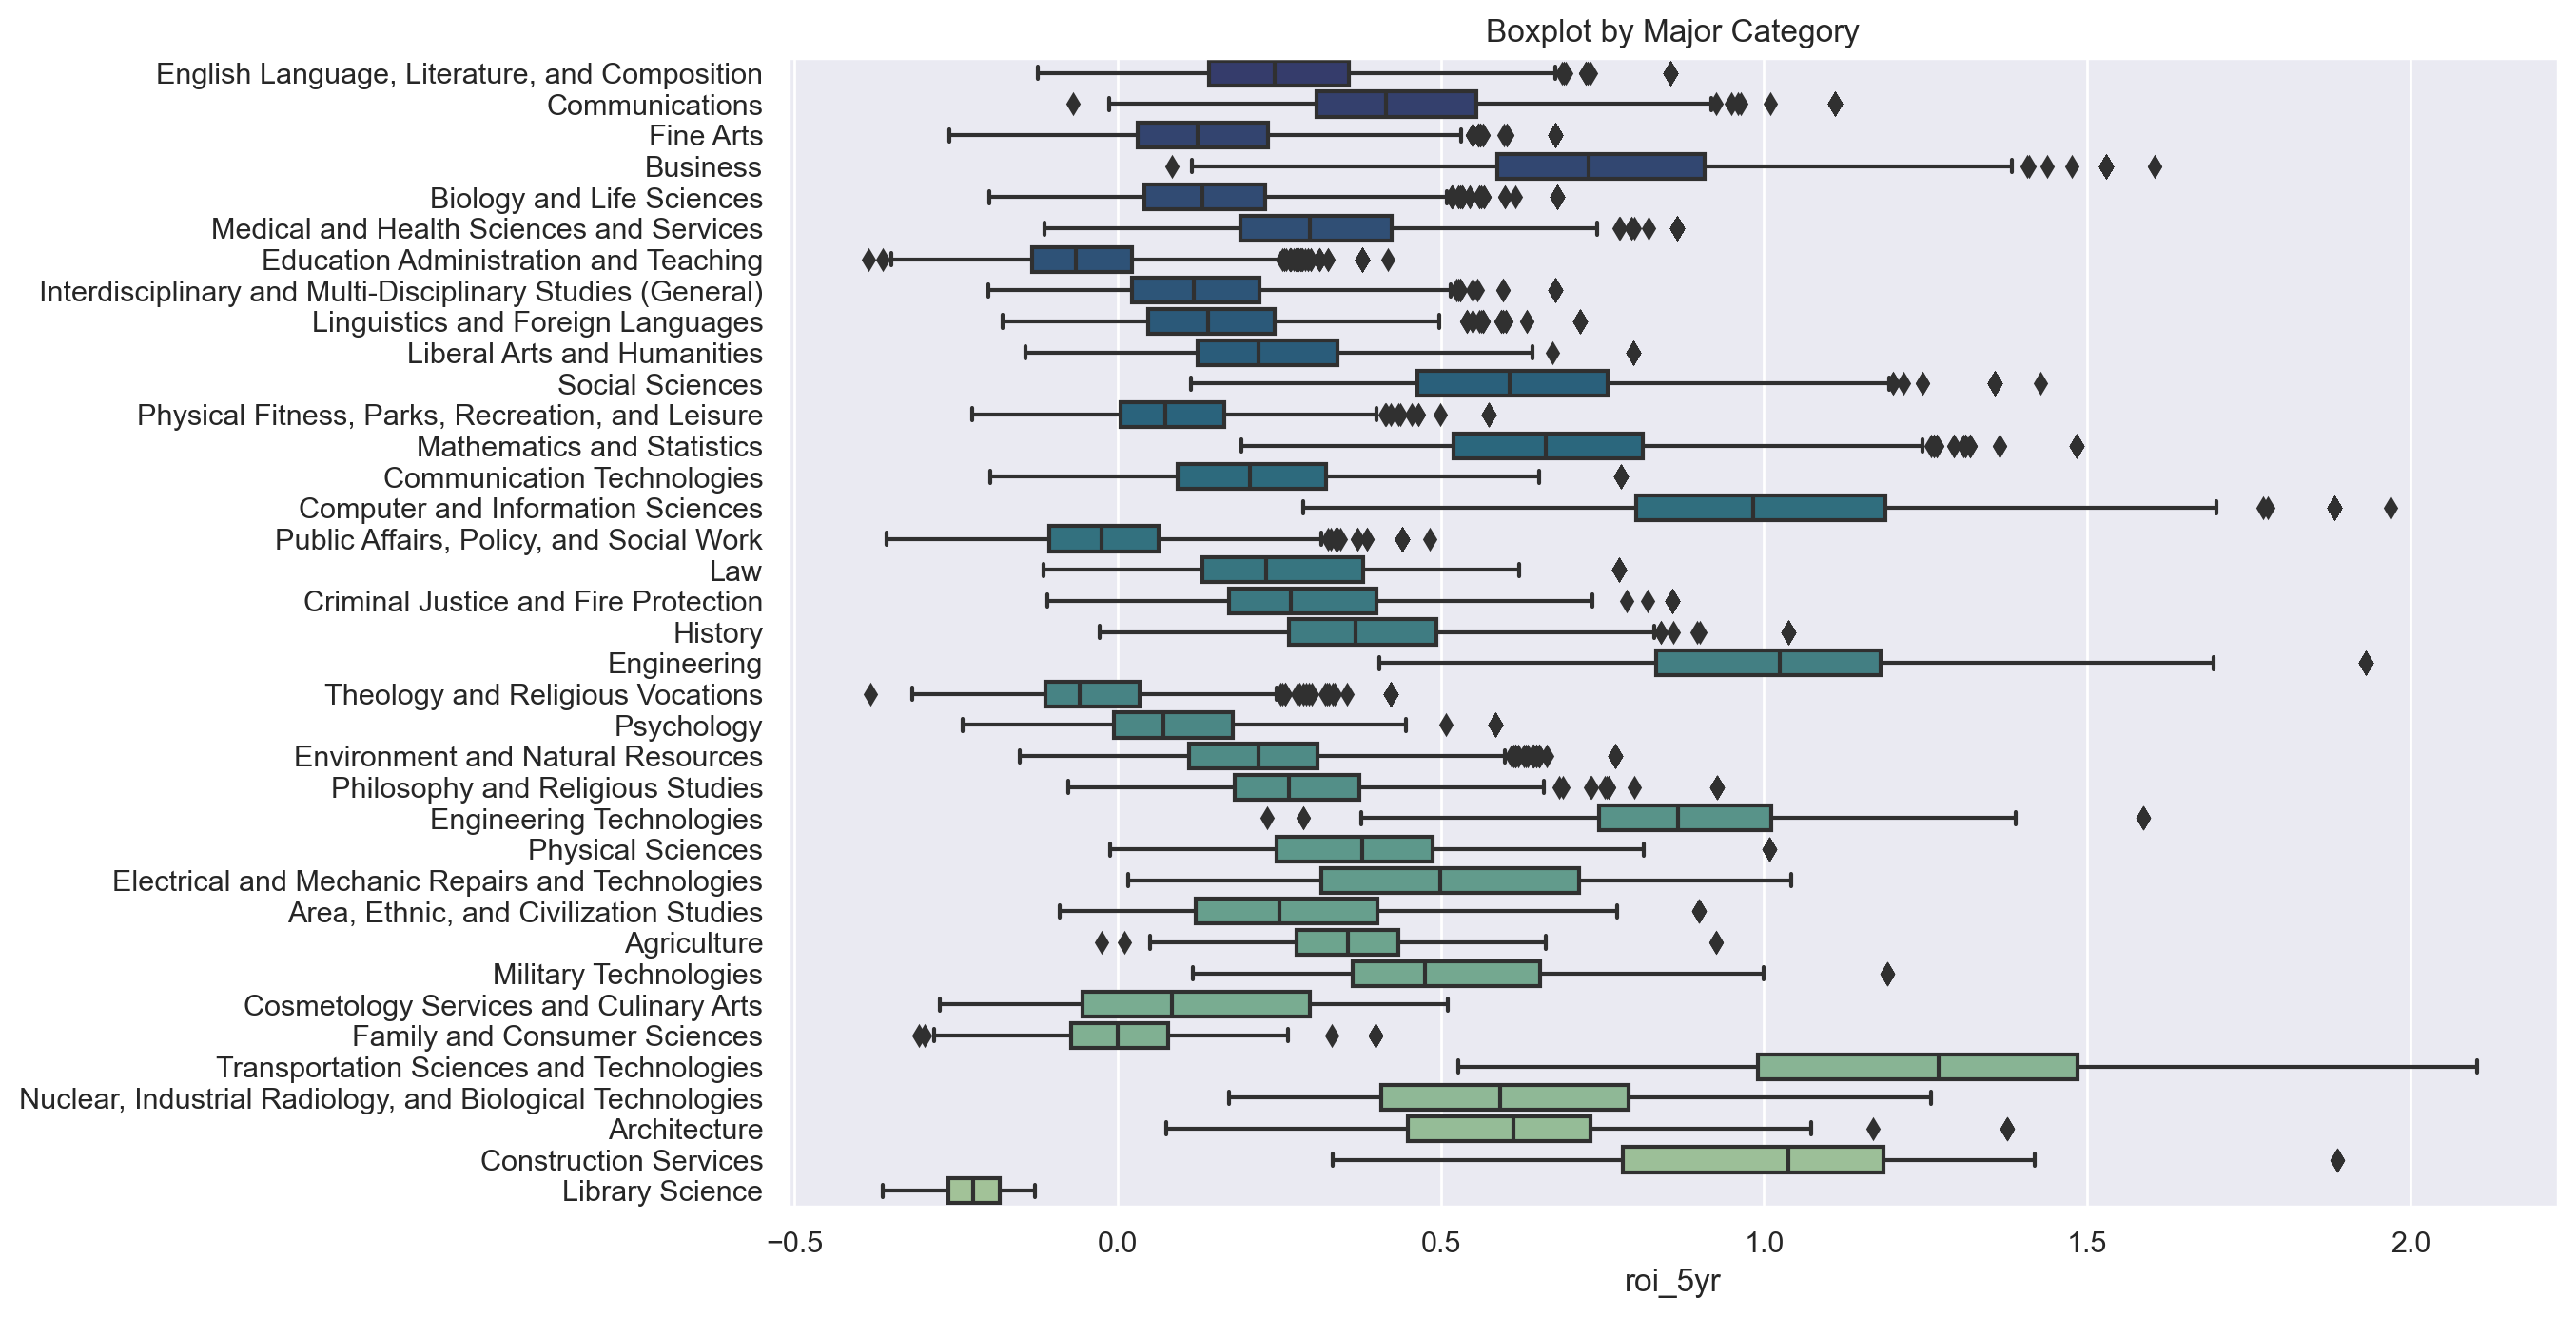

In [10]:
# central tendency at 5yr roi period by major

plt.figure(figsize = (12, 8))

sns.boxplot(
    x = "roi_5yr",
    y = "major_category",
    data = train_imputed,
    orient = "h",
    palette = "crest_r"
)

plt.title("Boxplot by Major Category")
plt.ylabel(None)
plt.show()

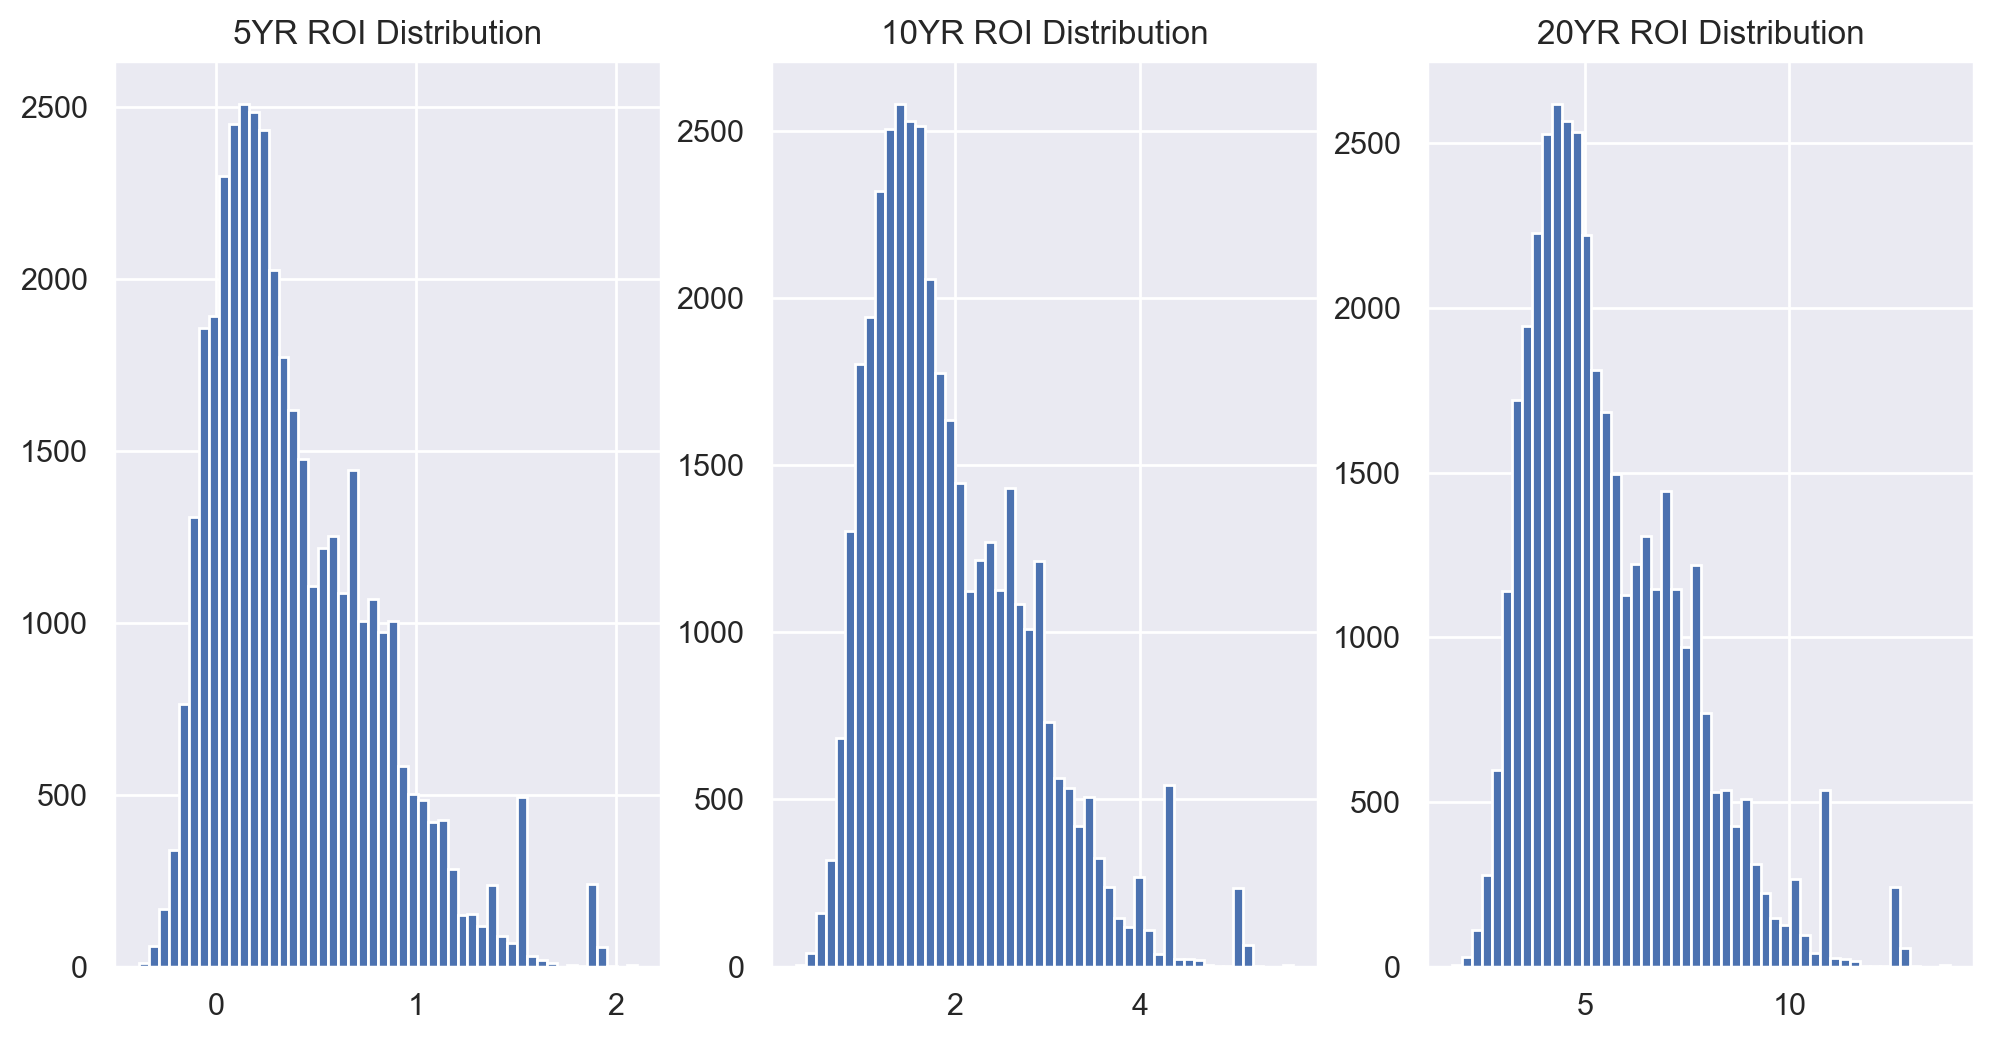

In [11]:
# side-by-side comparison of target variables

plt.subplots(nrows = 1, ncols = 2, figsize = (12, 6))

plt.subplot(131)
plt.title("5YR ROI Distribution")
plt.hist(train_imputed["roi_5yr"], bins = 50)

plt.subplot(132)
plt.title("10YR ROI Distribution")
plt.hist(train_imputed["roi_10yr"], bins = 50)

plt.subplot(133)
plt.title("20YR ROI Distribution")
plt.hist(train_imputed["roi_20yr"], bins = 50)

plt.show()

``additional variable creation``

In [ ]:
# add to final prepare file !
# [(0.404, 0.545], (0.545, 0.656], (0.656, 0.71], (0.71, 0.817], (0.817, 0.893]]
# national average is 68% acceptance rate 
# labels 
# 0.404, 0.545 == "very competitive"
# 0.545, 0.656 == "somewhat competitive"
# 0.656, 0.71 == "competitive"
# 0.71, 0.817 == "average acceptance"
# 0.817, 0.893 == "above average acceptance"

# train_imputed['admission_rate_binned'] = pd.qcut(
#     train_imputed['admission_rate'], \
#     q = 5, \
#     labels = ["very_competitive", "somewhat_competitive", "competitive", "average acceptance", "above_average_acceptance"])

# validate_imputed['admission_rate_binned'] = pd.qcut(
#     validate_imputed['admission_rate'], \
#     q = 5, \
#     labels = ["very_competitive", "somewhat_competitive", "competitive", "average acceptance", "above_average_acceptance"])

# test_imputed['admission_rate_binned'] = pd.qcut(
#     test_imputed['admission_rate'], \
#     q = 5, \
#     labels = ["very_competitive", "somewhat_competitive", "competitive", "average acceptance", "above_average_acceptance"])

# train_imputed[["admission_rate", "admission_rate_binned"]].head() # checks out

In [13]:
from scipy.stats import levene

admission = train_imputed["admission_rate"] 
entering = train_imputed["share_entering_students_first_ft"]

stat, p = levene(admission, entering)
p.round()

0.0

In [14]:
# retrieve newly created "first-time, full-time student bins" column

train_imputed, validate_imputed, test_imputed = prepare.get_share_bins(train_imputed, validate_imputed, test_imputed)

train shape: (39995, 115)
validate shape: (17142, 115)
test shape: (14285, 115)


``Creating Dummy Variables``

In [15]:
# create dummy datasets w/passed categorical columns

train_dummy, validate_dummy, test_dummy = prepare.get_dummy_dataframes(train_imputed, validate_imputed, test_imputed)

train shape: (39995, 169)
validate shape: (17142, 169)
test shape: (14285, 169)


``Scale Continuous Variables``

In [16]:
# identify continuous variables to scale - exclusive of target variables

cont_lst = train_dummy.select_dtypes(exclude = ["object", "category", "uint8", "int64", "bool"]).columns.tolist()

target_lst = [ 
        "roi_5yr",
        "roi_10yr",
        "roi_20yr",
        "pct_roi_5yr",
        "pct_roi_10yr",
        "pct_roi_20yr",
        "2017",                                               
        "2018",                                                   
        "2019",
        "Grand Total",
        "avg_net_price"
        ]

# final continuous variables list
cont_lst = [col for col in cont_lst if col not in target_lst]

In [17]:
# transform datasets

scaler = RobustScaler()

# fit scaled on training dataset
scaler.fit(train_dummy[cont_lst])

# transform dummy datasets
train_dummy[cont_lst] = scaler.transform(train_dummy[cont_lst])
validate_dummy[cont_lst] = scaler.transform(validate_dummy[cont_lst])
test_dummy[cont_lst] = scaler.transform(test_dummy[cont_lst])

# give new dataframe names
train_scaled = train_dummy
validate_scaled = validate_dummy
test_scaled = test_dummy

# non-dummy datasets (can be used for future comparison purposes)
train_imputed[cont_lst] = scaler.transform(train_imputed[cont_lst])
validate_imputed[cont_lst] = scaler.transform(validate_imputed[cont_lst])
test_imputed[cont_lst] = scaler.transform(test_imputed[cont_lst])

# inspect the dataset
train_scaled.head() # checks out!

unit_id_institution            college_name state_post_code  \
25530             0.443437   University of Memphis              TN   
53875             0.402047    Limestone University              SC   
42932             0.563267  Texas State University              TX   
45495            -0.732042       Judson University              IL   
25003             0.078220      Yeshiva University              NY   

         zip_code        city  region_ipeds  title_IV_eligibility  \
25530       38152     Memphis          0.25                   0.0   
53875  29340-3799     Gaffney          0.25                   0.0   
42932       78666  San Marcos          0.50                   0.0   
45495  60123-1498       Elgin         -0.25                   0.0   
25003  10033-3299    New York         -0.50                   0.0   

       pred_degree  pred_degree_0and4       degree_name  degree_code  \
25530          0.0                0.0  Bachelors Degree          0.0   
53875          0.0                0.0  Bachelors Degree          0.0   
42932          0.0                0.0  Bachelors Degree          0.0   
45495          0.0                0.0  Bachelors Degree          0.0   
25003          0.0                0.0  Bachelors Degree          0.0   

       major_code                                         major_name  \
25530   -0.823927                                        Journalism.   
53875   -0.823927                   Communication and Media Studies.   
42932    0.323339                           Design and Applied Arts.   
45495    0.381834                   Accounting and Related Services.   
25003   -0.673721  Classics and Classical Languages, Literatures,...   

       branch_number  avg_net_price_public  avg_net_price_private  \
25530            0.0              0.969139              -0.579450   
53875            0.0              0.000000               0.451192   
42932            0.0              1.091247              -0.579450   
45495            0.0              0.000000               0.297770   
25003            0.0              0.000000               0.682244   

       full_time_net_tuition_revenue  off_campus_cost_of_attendace  \
25530                      -0.446191                     -0.080134   
53875                       0.046191                     -0.718527   
42932                      -0.416483                     -0.393750   
45495                      -0.205367                     -0.520982   
25003                       0.502156                      0.658259   

       on_campus_cost_of_attendace  admission_rate  graduate_number  \
25530                    -0.196989        0.754616         0.970925   
53875                    -0.552300       -1.195821        -0.303124   
42932                    -0.292896        0.437804         1.042685   
45495                    -0.193031        0.108844        -0.267244   
25003                     0.419553       -0.412536         0.824312   

       ACT_score_mid  avg_sat_admitted  required_score  avg_faculty_salary  \
25530      -0.333333         -0.132566             0.0            0.212325   
53875      -1.000000         -0.997371             0.0           -0.719918   
42932      -0.333333         -0.398660             0.0           -0.060456   
45495      -0.666667         -0.653666             0.0           -0.523949   
25003       0.666667          1.264428             0.0            1.159755   

       online_only  comp_rt_ft_150over_expected_time  \
25530          0.0                         -0.402551   
53875          0.0                         -0.851169   
42932          0.0                         -0.130758   
45495          0.0                          0.158753   
25003          0.0                          0.848689   

       comp_rt_ft_150over_expected_time_two_races  \
25530                                   -0.327888   
53875                                   -0.087453   
42932                                    0.204921   
45495                   

In [46]:
# cluster number 1: Admission Rate Cluster
# setting features to cluster on 

X_admission = train_scaled[[
'income_48001_75000',
'admission_rate_binned_very_competitive',	
'admission_rate_binned_somewhat_competitive',	
'admission_rate_binned_competitive',	
'admission_rate_binned_average_acceptance',	
'admission_rate_binned_above_average_acceptance'
    ]]

# validate df
X_val = validate_scaled[[
'income_48001_75000',
'admission_rate_binned_very_competitive',	
'admission_rate_binned_somewhat_competitive',	
'admission_rate_binned_competitive',	
'admission_rate_binned_average_acceptance',	
'admission_rate_binned_above_average_acceptance'
    ]]

# test df
X_test = test_scaled[[
'income_48001_75000',
'admission_rate_binned_very_competitive',	
'admission_rate_binned_somewhat_competitive',	
'admission_rate_binned_competitive',	
'admission_rate_binned_average_acceptance',	
'admission_rate_binned_above_average_acceptance'
    ]]

X_admission.head()

income_48001_75000  admission_rate_binned_very_competitive  \
25530            1.429688                                   False   
53875           -0.062500                                    True   
42932            1.859375                                   False   
45495           -0.218750                                   False   
25003           -0.242188                                   False   

       admission_rate_binned_somewhat_competitive  \
25530                                       False   
53875                                       False   
42932                                       False   
45495                                       False   
25003                                        True   

       admission_rate_binned_competitive  \
25530                              False   
53875                              False   
42932                              False   
45495                              False   
25003                              False   

       admission_rate_binned_average_acceptance  \
25530                                     False   
53875                                     False   
42932                                      True   
45495                                      True   
25003                                     False   

       admission_rate_binned_above_average_acceptance  
25530                                            True  
53875                                           False  
42932                                           False  
45495                                           False  
25003                                           False

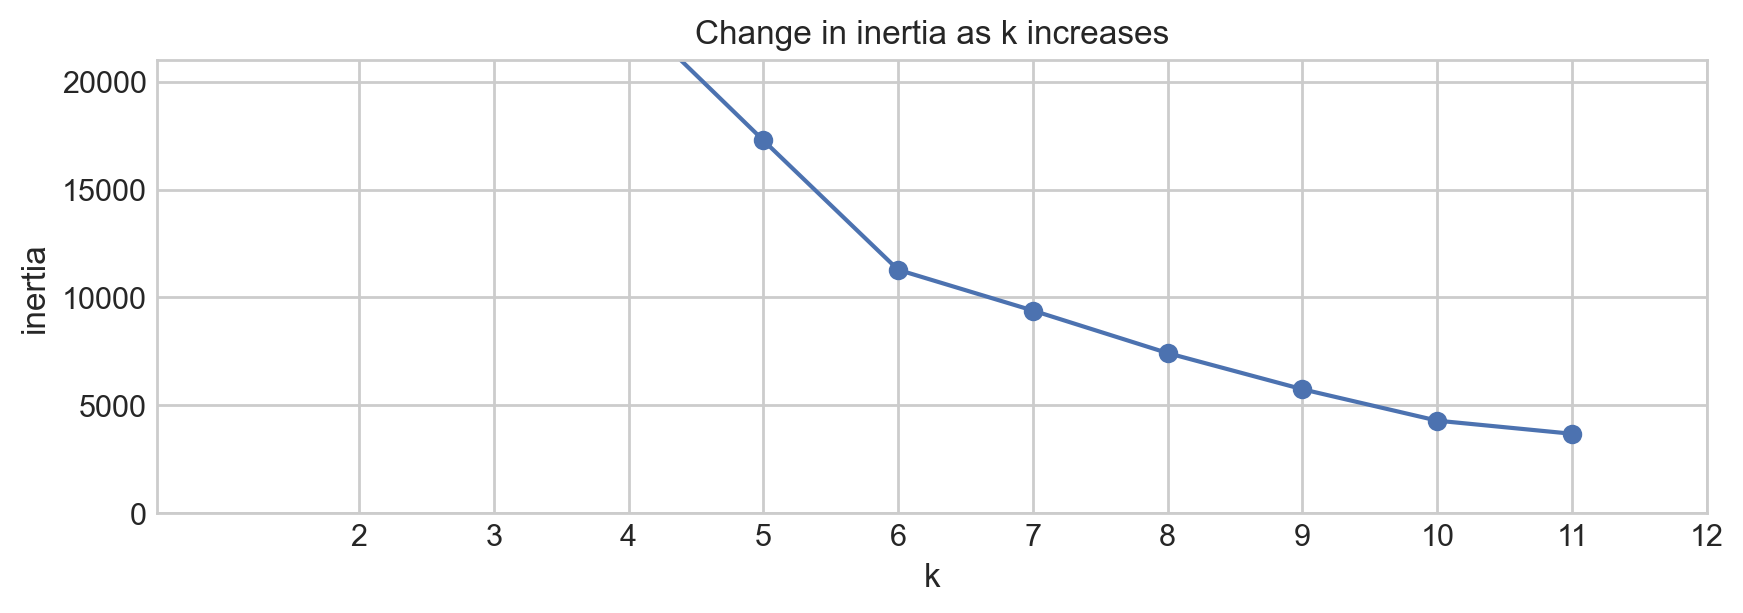

In [21]:
# KMeans Elbow-method

with plt.style.context('seaborn-whitegrid'):

    plt.figure(figsize=(10, 3))
    pd.Series({k: KMeans(k).fit(X_admission).inertia_ for k in range(1, 12)}).plot(marker = 'o')
    plt.xticks(range(2, 13))
    
    plt.ylim(0, 21000)
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

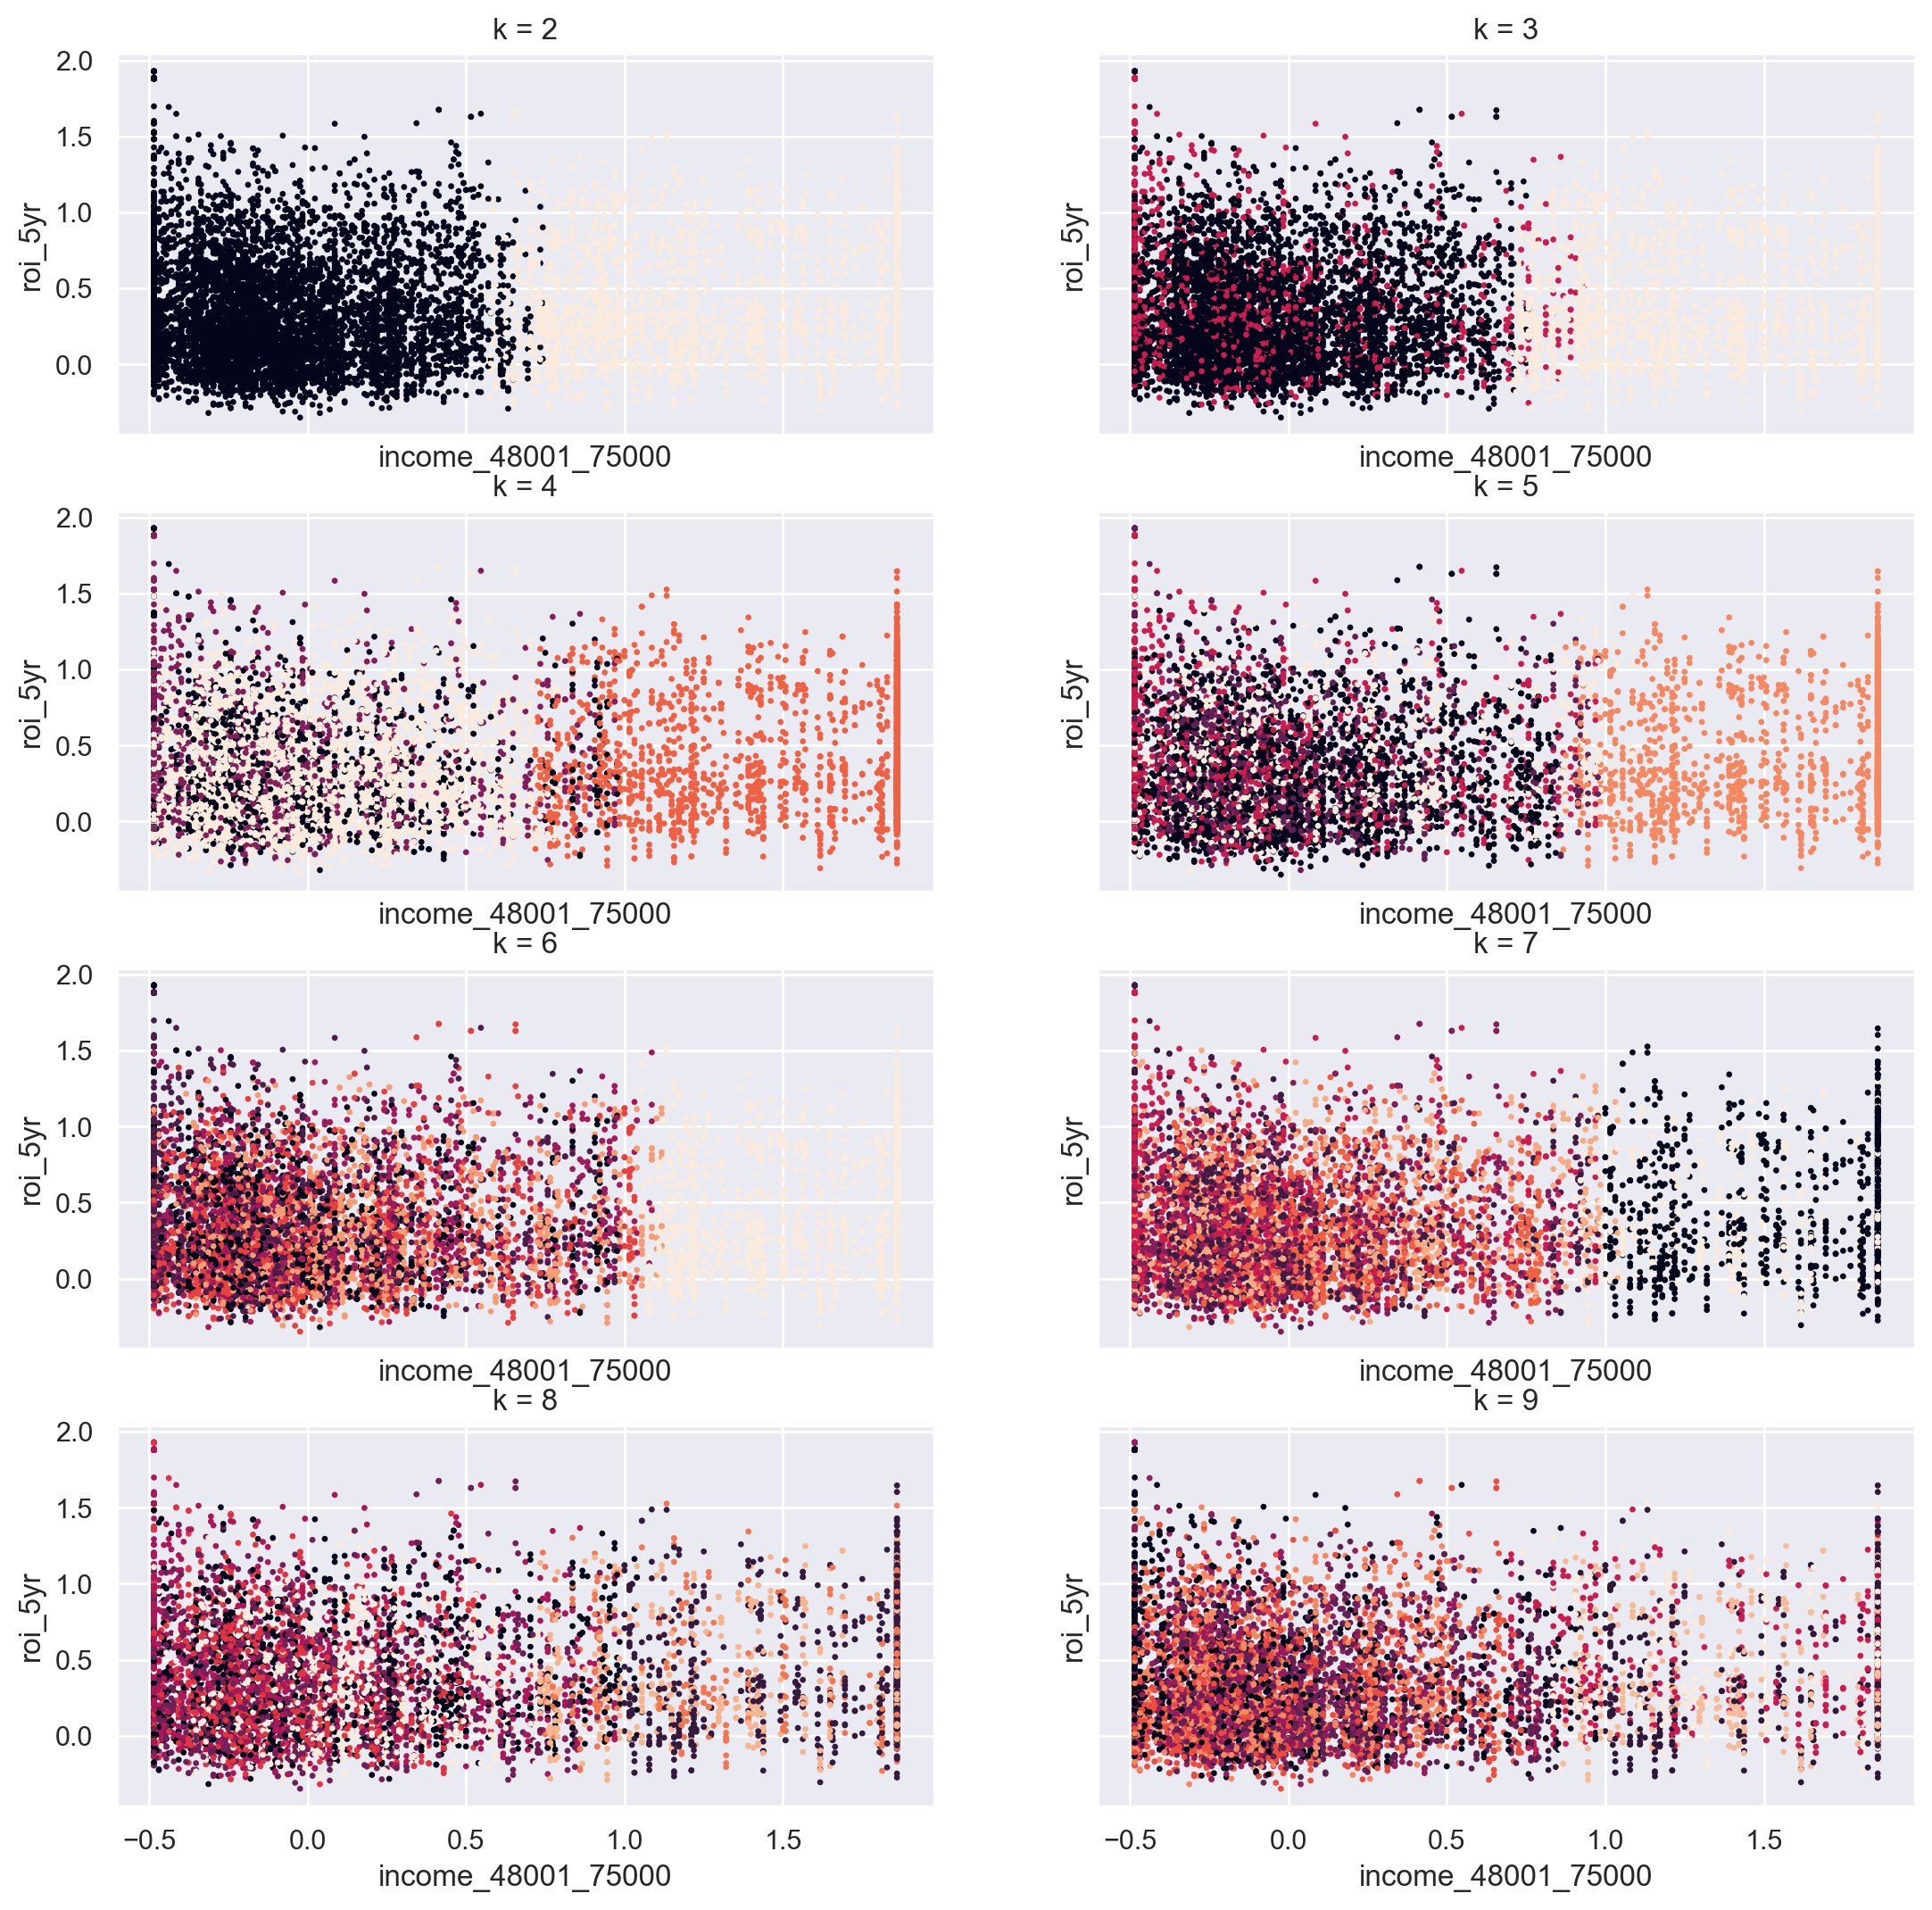

In [23]:
# plotting inertia for number of KMeans clusters

fig, axs = plt.subplots(4, 2, figsize=(13, 13), sharex=True, sharey=True)

for ax, k in zip(axs.ravel(), range(2, 13)):
    
    X1 = X_admission.sample(10000, random_state = 123)

    # creating and fitting KMeans
    clusters = KMeans(k).fit(X1).predict(X1)

    X1["roi_5yr"] = train_scaled["roi_5yr"]

    ax.scatter(
        X1["income_48001_75000"],
        X1["roi_5yr"],
        c = clusters,
        s = 2)

    ax.set(title='k = {}'.format(k), xlabel = 'income_48001_75000', ylabel = 'roi_5yr')

In [25]:
# measure correlation

for n_cluster in range(2, 11):

    kmeans = KMeans(n_clusters = n_cluster).fit(X1)

    label = kmeans.labels_

    sil_coeff = silhouette_score(X1, label, metric='euclidean')
    
    print("For n_clusters = {}, The Silhouette Coefficient is {:.4f}".format(n_cluster, sil_coeff))


# obtaining the best coefficient results at n_clusters = 9: using sklearn silhouette coefficient method

For n_clusters = 2, The Silhouette Coefficient is 0.3146
For n_clusters = 3, The Silhouette Coefficient is 0.2713
For n_clusters = 4, The Silhouette Coefficient is 0.3413
For n_clusters = 5, The Silhouette Coefficient is 0.4185
For n_clusters = 6, The Silhouette Coefficient is 0.4975
For n_clusters = 7, The Silhouette Coefficient is 0.5013
For n_clusters = 8, The Silhouette Coefficient is 0.5215
For n_clusters = 9, The Silhouette Coefficient is 0.5380
For n_clusters = 10, The Silhouette Coefficient is 0.5288


In [47]:
# initial fitting of KMeans cluster

kmeans = KMeans(n_clusters = 5)
kmeans.fit(X_admission)

train_clusters = kmeans.predict(X_admission)

In [48]:
# creating cluster for ea. dataset 

train_admission_clusters = kmeans.predict(X_admission)
val_admission_clusters = kmeans.predict(X_val)
test_admission_clusters = kmeans.predict(X_test)

# viewing cluster samples
pd.DataFrame(train_admission_clusters).rename(columns = {0: "Cluster Sample"}).sample(10, random_state = 123)

Cluster Sample
21417               1
28667               4
7477                3
24935               4
24966               3
7142                3
30603               4
7930                2
31203               4
1107                3

In [49]:
# adding clusters back to original datasets

train_scaled["admission_clusters_5yr"] = train_admission_clusters
validate_scaled["admission_clusters_5yr"] = val_admission_clusters
test_scaled["admission_clusters_5yr"] = test_admission_clusters

train_scaled.head()

unit_id_institution            college_name state_post_code  \
25530             0.443437   University of Memphis              TN   
53875             0.402047    Limestone University              SC   
42932             0.563267  Texas State University              TX   
45495            -0.732042       Judson University              IL   
25003             0.078220      Yeshiva University              NY   

         zip_code        city  region_ipeds  title_IV_eligibility  \
25530       38152     Memphis          0.25                   0.0   
53875  29340-3799     Gaffney          0.25                   0.0   
42932       78666  San Marcos          0.50                   0.0   
45495  60123-1498       Elgin         -0.25                   0.0   
25003  10033-3299    New York         -0.50                   0.0   

       pred_degree  pred_degree_0and4       degree_name  degree_code  \
25530          0.0                0.0  Bachelors Degree          0.0   
53875          0.0                0.0  Bachelors Degree          0.0   
42932          0.0                0.0  Bachelors Degree          0.0   
45495          0.0                0.0  Bachelors Degree          0.0   
25003          0.0                0.0  Bachelors Degree          0.0   

       major_code                                         major_name  \
25530   -0.823927                                        Journalism.   
53875   -0.823927                   Communication and Media Studies.   
42932    0.323339                           Design and Applied Arts.   
45495    0.381834                   Accounting and Related Services.   
25003   -0.673721  Classics and Classical Languages, Literatures,...   

       branch_number  avg_net_price_public  avg_net_price_private  \
25530            0.0              0.969139              -0.579450   
53875            0.0              0.000000               0.451192   
42932            0.0              1.091247              -0.579450   
45495            0.0              0.000000               0.297770   
25003            0.0              0.000000               0.682244   

       full_time_net_tuition_revenue  off_campus_cost_of_attendace  \
25530                      -0.446191                     -0.080134   
53875                       0.046191                     -0.718527   
42932                      -0.416483                     -0.393750   
45495                      -0.205367                     -0.520982   
25003                       0.502156                      0.658259   

       on_campus_cost_of_attendace  admission_rate  graduate_number  \
25530                    -0.196989        0.754616         0.970925   
53875                    -0.552300       -1.195821        -0.303124   
42932                    -0.292896        0.437804         1.042685   
45495                    -0.193031        0.108844        -0.267244   
25003                     0.419553       -0.412536         0.824312   

       ACT_score_mid  avg_sat_admitted  required_score  avg_faculty_salary  \
25530      -0.333333         -0.132566             0.0            0.212325   
53875      -1.000000         -0.997371             0.0           -0.719918   
42932      -0.333333         -0.398660             0.0           -0.060456   
45495      -0.666667         -0.653666             0.0           -0.523949   
25003       0.666667          1.264428             0.0            1.159755   

       online_only  comp_rt_ft_150over_expected_time  \
25530          0.0                         -0.402551   
53875          0.0                         -0.851169   
42932          0.0                         -0.130758   
45495          0.0                          0.158753   
25003          0.0                          0.848689   

       comp_rt_ft_150over_expected_time_two_races  \
25530                                   -0.327888   
53875                                   -0.087453   
42932                                    0.204921   
45495                   

In [30]:
# printing average admissions rate by admission cluster

unique_clusters = sorted(train_scaled["admission_clusters_5yr"].unique().tolist())

container = []

for cluster in unique_clusters:
    
    metric = {
    'admission cluster': cluster,
    'admission rate': round(train_scaled[train_scaled["admission_clusters_5yr"] == cluster]["admission_rate"].mean(), 3),
    'min 5YR ROI': round(train_scaled[train_scaled["admission_clusters_5yr"] == cluster]["roi_5yr"].min(), 3),
    'max 5YR ROI': round(train_scaled[train_scaled["admission_clusters_5yr"] == cluster]["roi_5yr"].max(), 3),
    'range of 5YR ROI': round((train_scaled[train_scaled["admission_clusters_5yr"] == cluster]["roi_5yr"].max() - train_scaled[train_scaled["admission_clusters_5yr"] == cluster]["roi_5yr"].min()), 2),
    'average 5YR ROI': round(train_scaled[train_scaled["admission_clusters_5yr"] == cluster]["roi_5yr"].mean(), 3)
    }

    container.append(metric)

cluster_description = pd.DataFrame(container).sort_values(by = "average 5YR ROI", ascending = False).reset_index(drop = True)
cluster_description

admission cluster  admission rate  min 5YR ROI  max 5YR ROI  \
0                  4          -0.015       -0.295        2.103   
1                  5          -0.090       -0.339        1.804   
2                  3          -0.344       -0.363        1.930   
3                  2           0.903       -0.319        1.883   
4                  1          -1.184       -0.385        1.930   
5                  0           0.373       -0.322        1.930   

   range of 5YR ROI  average 5YR ROI  
0              2.40            0.549  
1              2.14            0.429  
2              2.29            0.396  
3              2.20            0.357  
4              2.32            0.306  
5              2.25            0.302

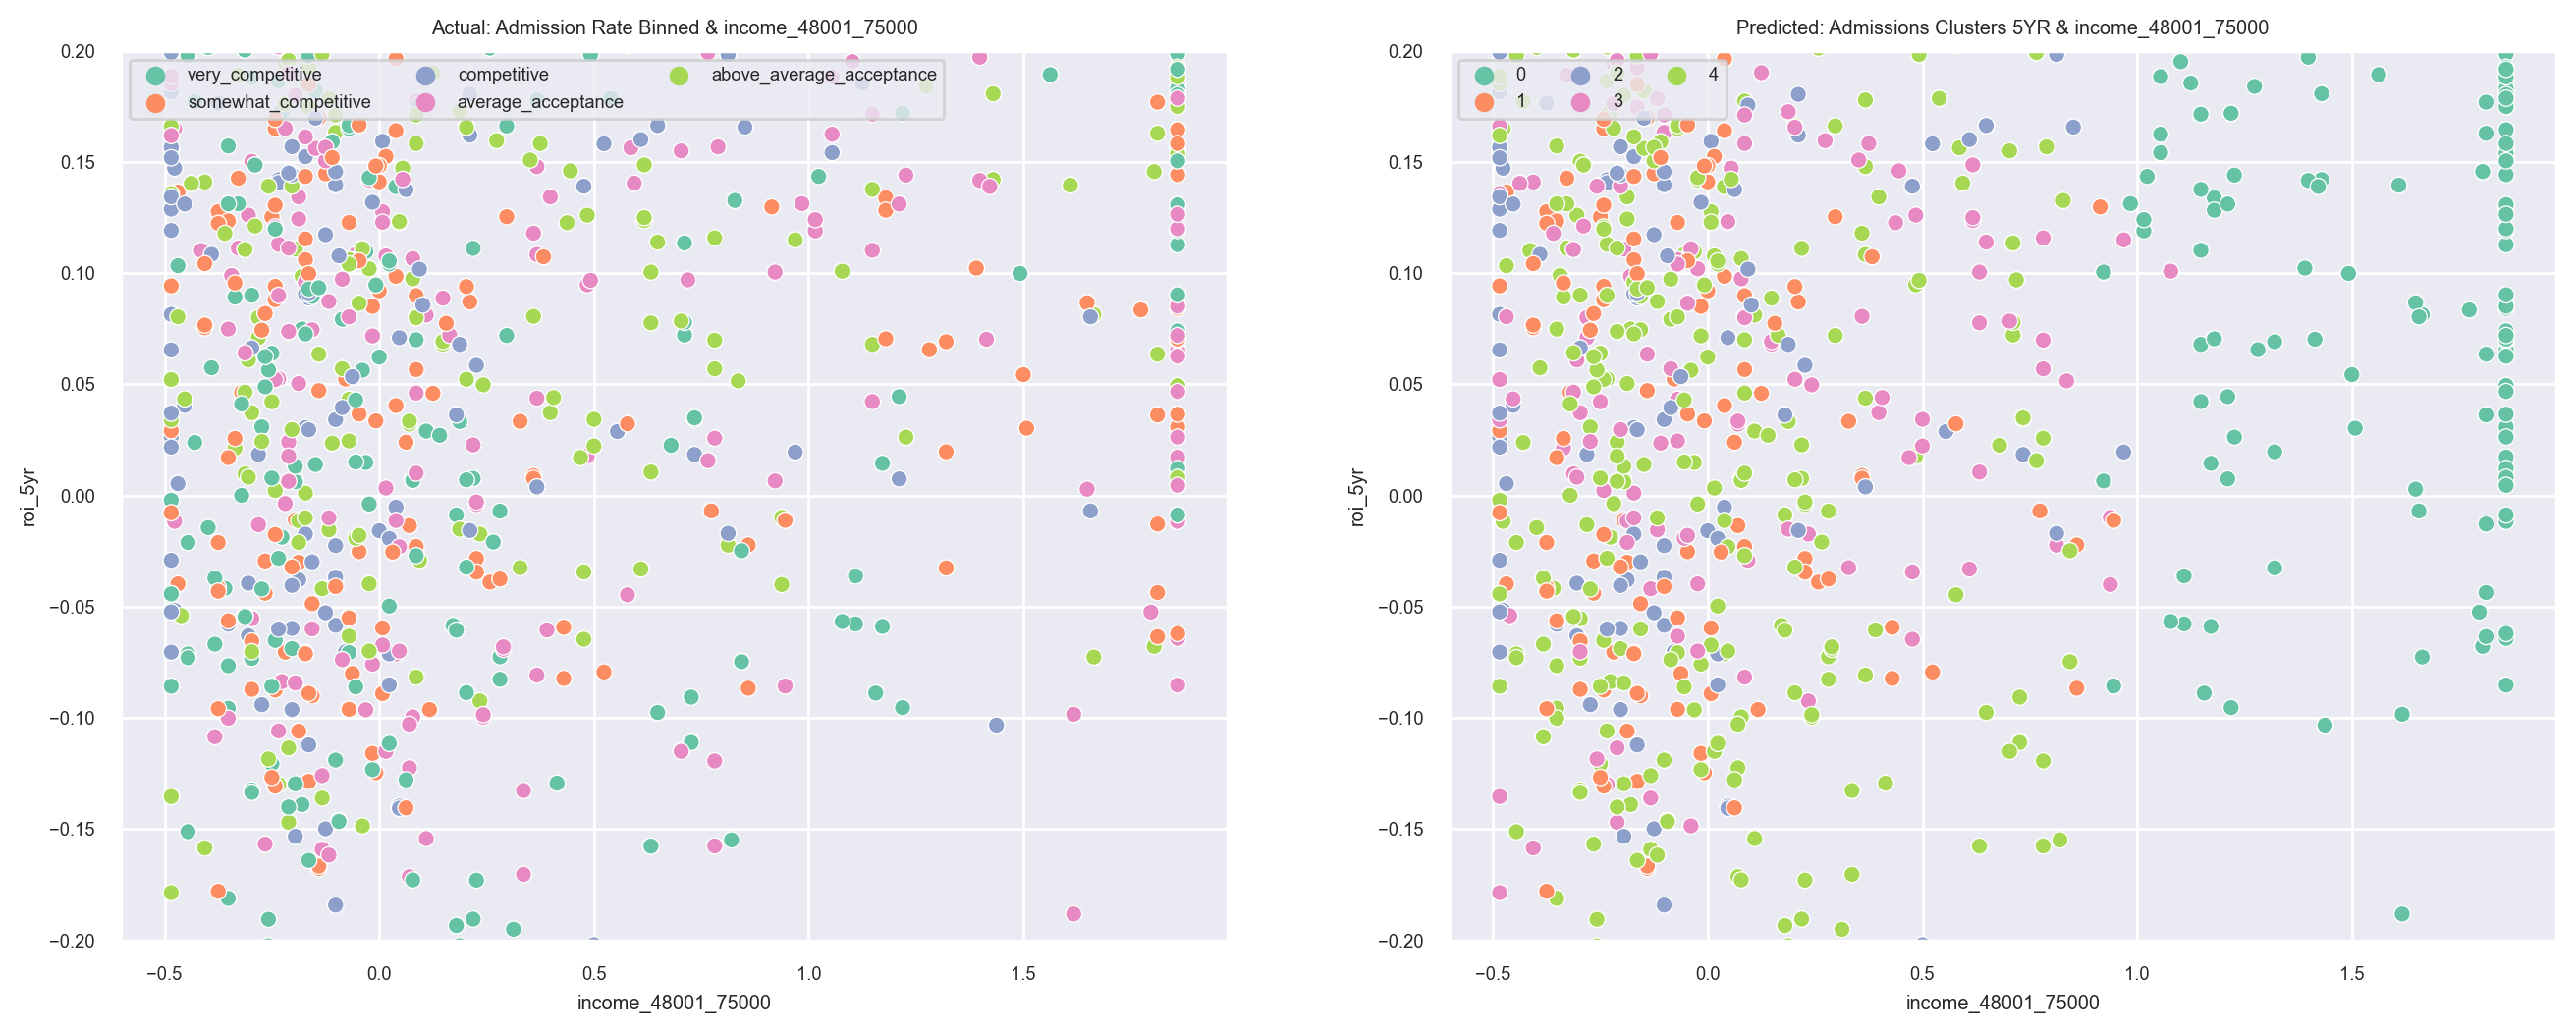

In [51]:
# seeing how month clusters compare against actual month and home age

sns.set(font_scale = 0.6)
plt.subplots(1, 2, figsize = (16, 6), sharex = False, sharey = False)

plt.subplot(121)
sns.scatterplot(
        x = "income_48001_75000",
        y = "roi_5yr",
        data = train_imputed.sample(2000, random_state = 123), 
        hue = "admission_rate_binned",
        palette = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854']
)

plt.title("Actual: Admission Rate Binned & income_48001_75000")
plt.legend(loc = 'upper left', ncol = 3)
plt.ylim(-.2, .2)

plt.subplot(122)
sns.scatterplot(
        x = "income_48001_75000",
        y = "roi_5yr",
        data = train_scaled.sample(2000, random_state = 123), 
        hue = "admission_clusters_5yr",
        palette = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854']
)

plt.title("Predicted: Admissions Clusters 5YR & income_48001_75000")
plt.legend(loc = 'upper left', ncol = 3)
plt.ylim(-.2, .2)
plt.show()

In [31]:
# Cluster Number 2: Institution Control
# setting features to cluster on 

X_control = train_scaled[[
    'admission_rate',
    'institution_control_Foreign',
    'institution_control_Private, for-profit',
    'institution_control_Private, nonprofit',
    'institution_control_Public'
    ]]

# validate df
X_val = validate_scaled[[
    'admission_rate',
    'institution_control_Foreign',
    'institution_control_Private, for-profit',
    'institution_control_Private, nonprofit',
    'institution_control_Public'
    ]]

# test df
X_test = test_scaled[[
    'admission_rate',
    'institution_control_Foreign',
    'institution_control_Private, for-profit',
    'institution_control_Private, nonprofit',
    'institution_control_Public'
    ]]

X_control.head()

admission_rate  institution_control_Foreign  \
25530        0.754616                        False   
53875       -1.195821                        False   
42932        0.437804                        False   
45495        0.108844                        False   
25003       -0.412536                        False   

       institution_control_Private, for-profit  \
25530                                    False   
53875                                    False   
42932                                    False   
45495                                    False   
25003                                    False   

       institution_control_Private, nonprofit  institution_control_Public  
25530                                   False                        True  
53875                                    True                       False  
42932                                   False                        True  
45495                                    True                       False  
25003                                    True                       False

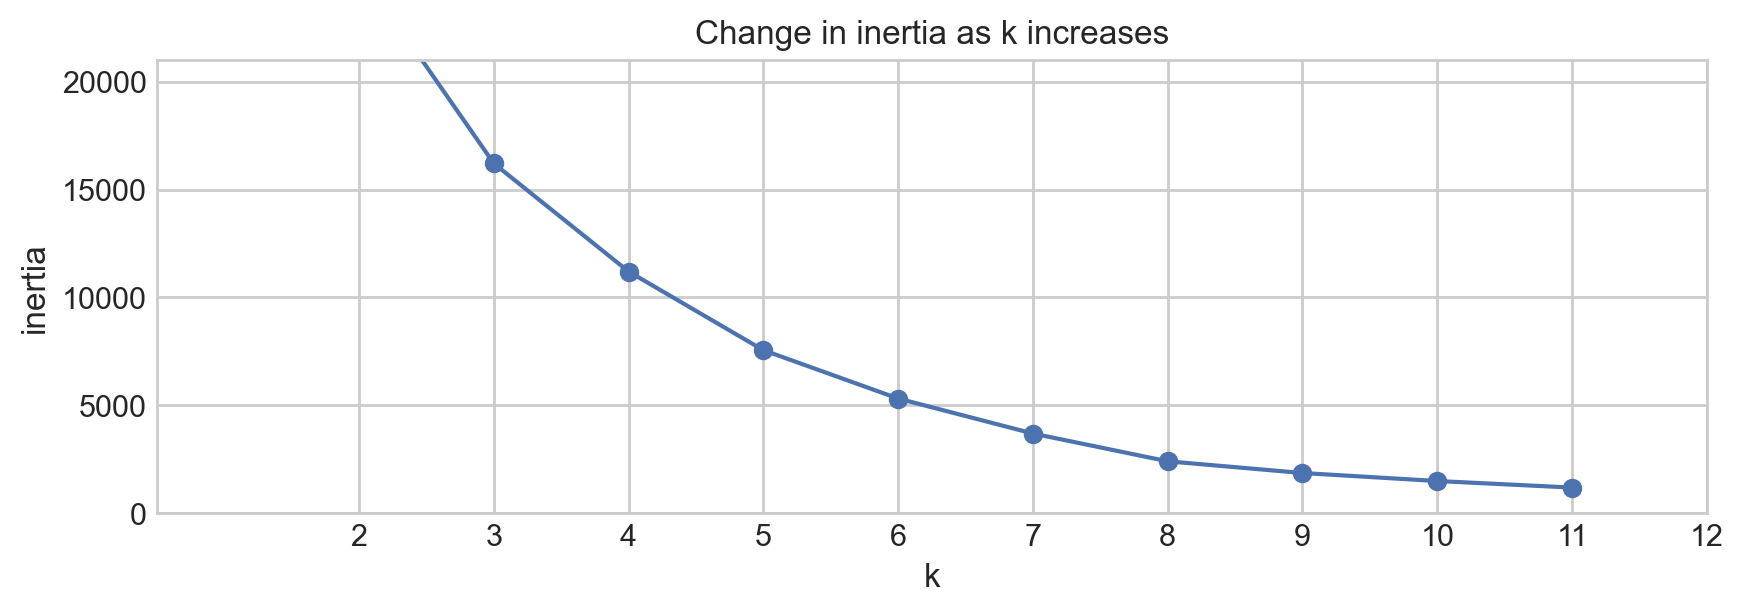

In [32]:
# KMeans Elbow-method

with plt.style.context('seaborn-whitegrid'):

    plt.figure(figsize=(10, 3))
    pd.Series({k: KMeans(k).fit(X_control).inertia_ for k in range(1, 12)}).plot(marker = 'o')
    plt.xticks(range(2, 13))
    
    plt.ylim(0, 21000)
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

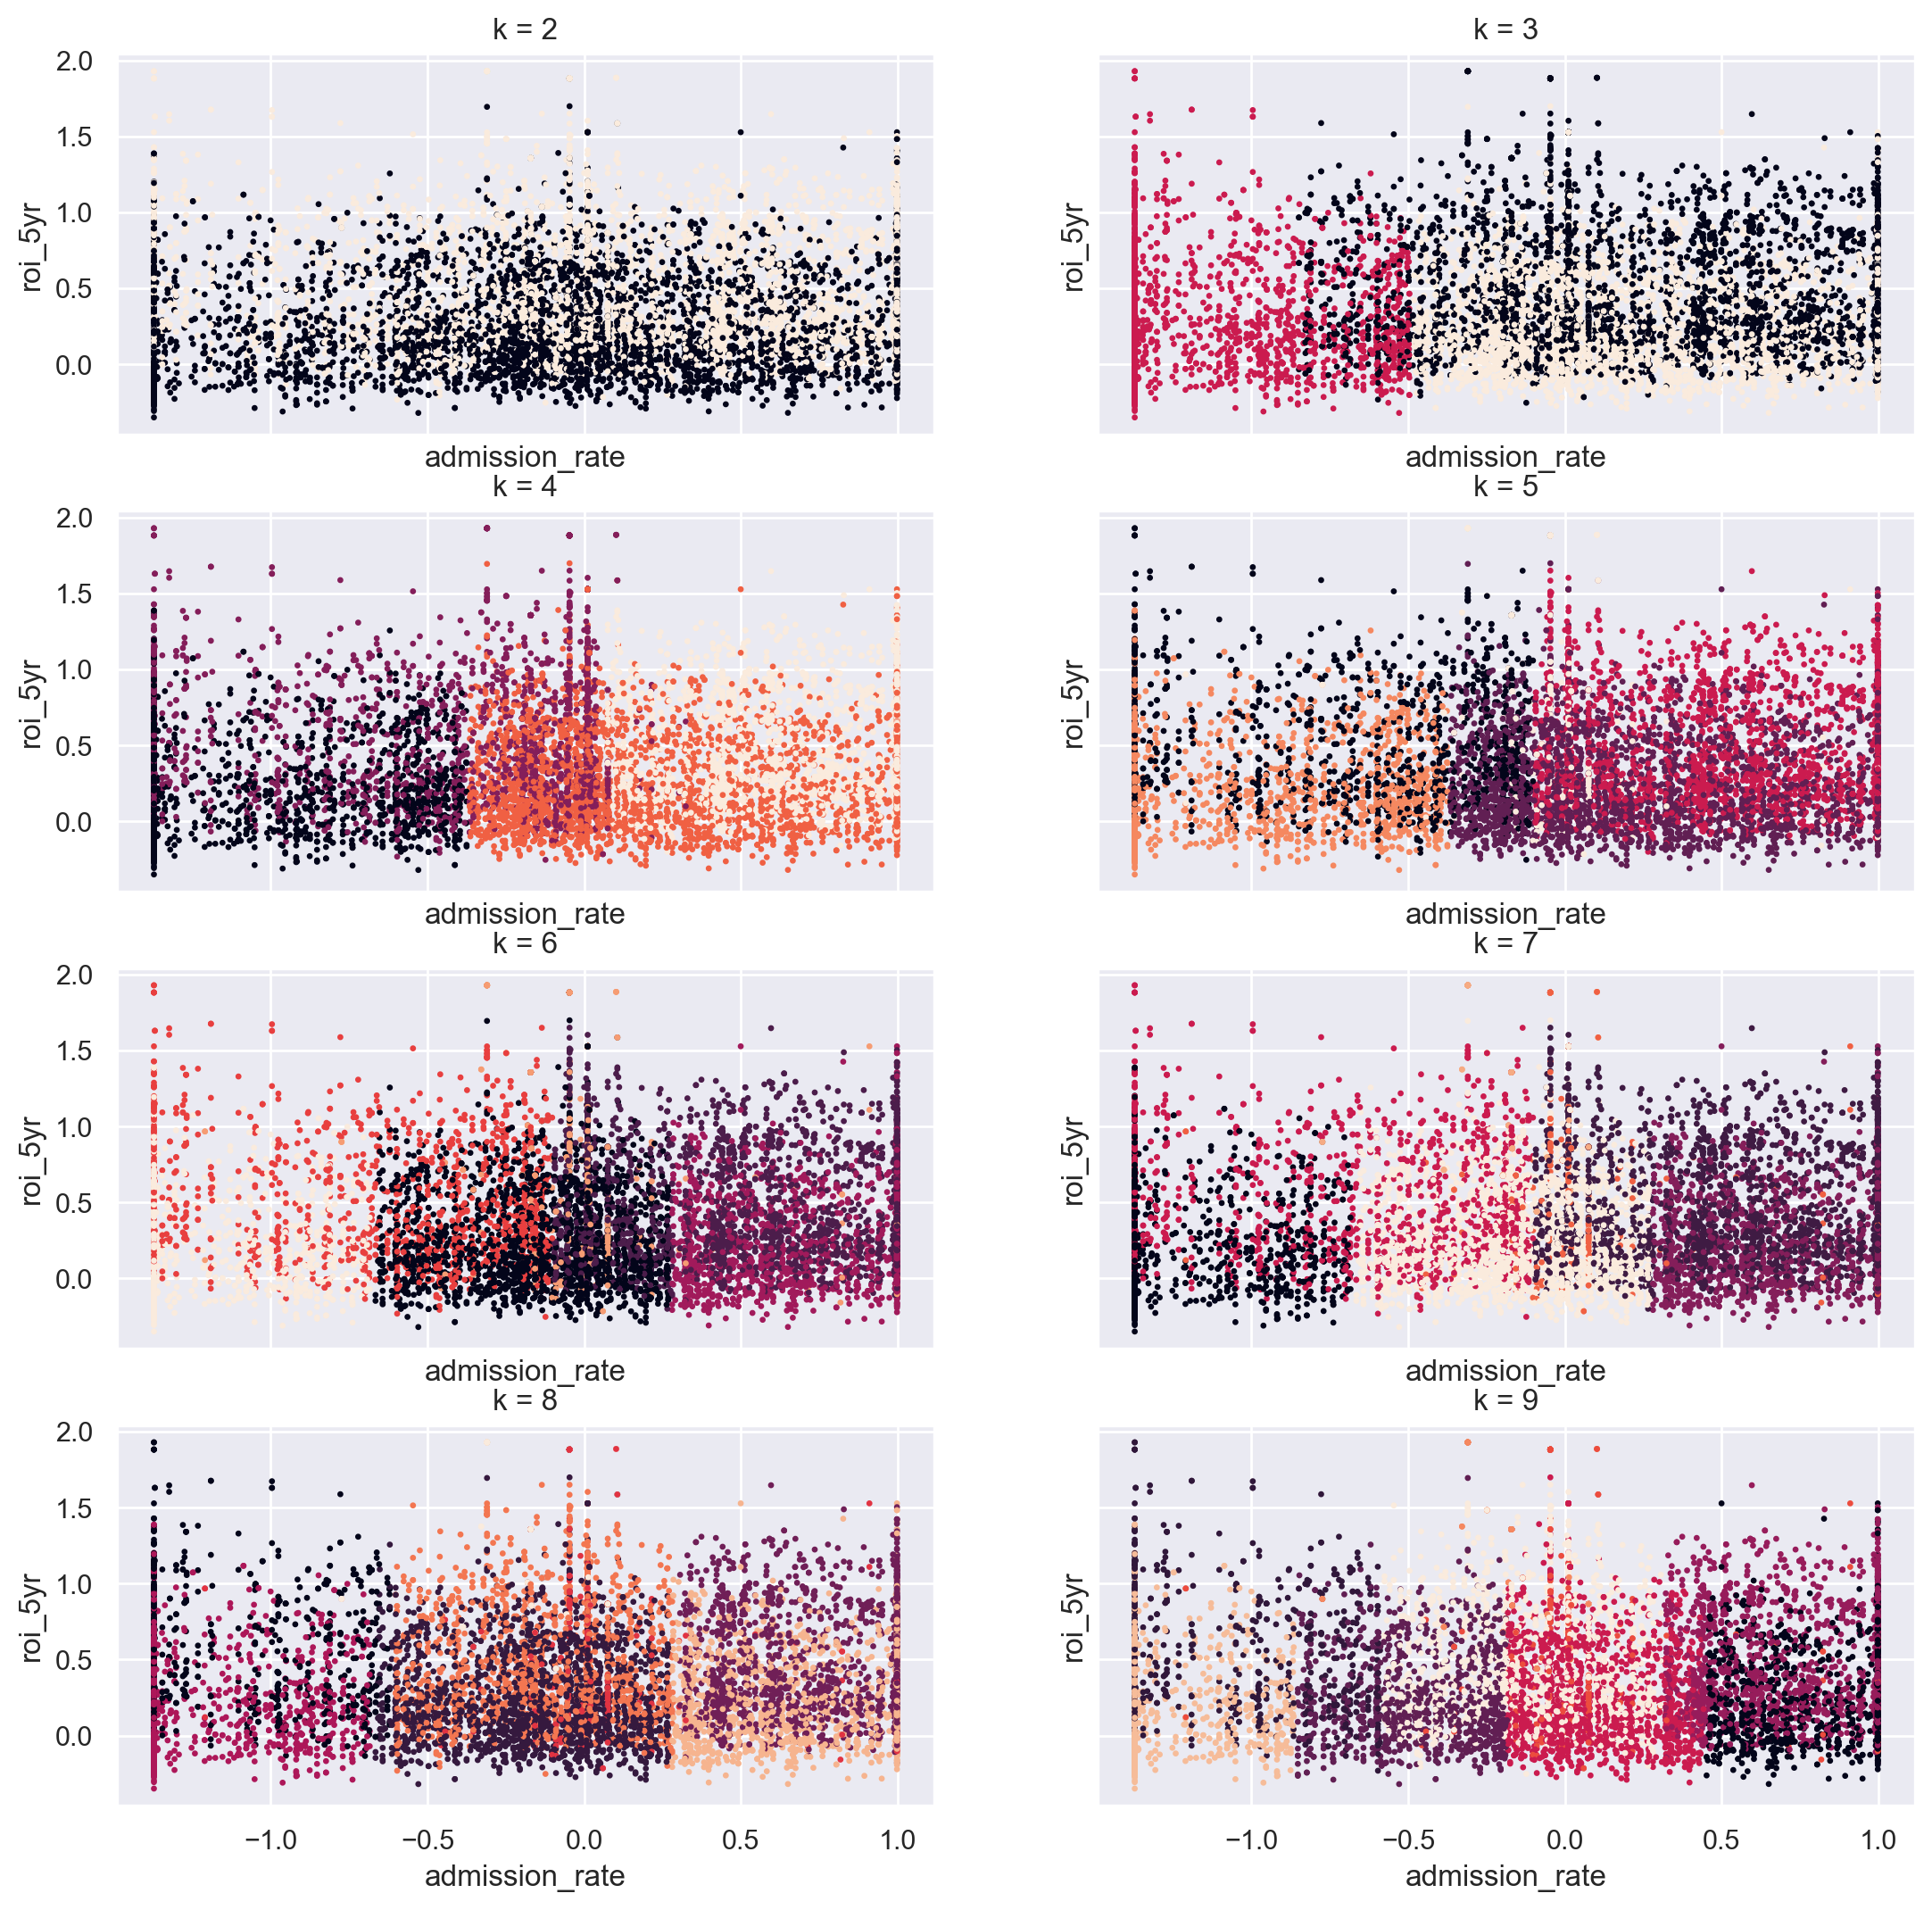

In [33]:
# plotting inertia for number of KMeans clusters

fig, axs = plt.subplots(4, 2, figsize=(13, 13), sharex=True, sharey=True)

for ax, k in zip(axs.ravel(), range(2, 13)):
    
    X1 = X_control.sample(10000, random_state = 123)

    # creating and fitting KMeans
    clusters = KMeans(k).fit(X1).predict(X1)

    X1["roi_5yr"] = train_scaled["roi_5yr"]

    ax.scatter(
        X1["admission_rate"],
        X1["roi_5yr"],
        c = clusters,
        s = 2)

    ax.set(title='k = {}'.format(k), xlabel = 'admission_rate', ylabel = 'roi_5yr')

In [34]:

for n_cluster in range(2, 11):

    kmeans = KMeans(n_clusters = n_cluster).fit(X1)

    label = kmeans.labels_

    sil_coeff = silhouette_score(X1, label, metric='euclidean')
    
    print("For n_clusters = {}, The Silhouette Relative from Previous Coefficient is {:.4f}".format(n_cluster, sil_coeff))
    
# obtaining the best coefficient results at n_clusters = 5: using sklearn silhouette coefficient method

For n_clusters = 2, The Silhouette Coefficient is 0.4049
For n_clusters = 3, The Silhouette Coefficient is 0.4032
For n_clusters = 4, The Silhouette Coefficient is 0.4035
For n_clusters = 5, The Silhouette Coefficient is 0.4539
For n_clusters = 6, The Silhouette Coefficient is 0.4335
For n_clusters = 7, The Silhouette Coefficient is 0.4203
For n_clusters = 8, The Silhouette Coefficient is 0.4385
For n_clusters = 9, The Silhouette Coefficient is 0.4372
For n_clusters = 10, The Silhouette Coefficient is 0.4392


In [35]:
# fitting of KMeans n_cluster to 3

kmeans = KMeans(n_clusters = 3)
kmeans.fit(X_control)

train_clusters = kmeans.predict(X_control)

In [36]:
# creating cluster for ea. dataset 

train_control_clusters = kmeans.predict(X_control)
val_control_clusters = kmeans.predict(X_val)
test_control_clusters = kmeans.predict(X_test)

# viewing cluster samples
pd.DataFrame(train_control_clusters).rename(columns = {0: "Cluster Sample"}).sample(10, random_state = 123)

Cluster Sample
21417               2
28667               2
7477                2
24935               0
24966               2
7142                2
30603               1
7930                0
31203               2
1107                0

In [37]:
# adding clusters back to original datasets

train_scaled["control_clusters_5yr"] = train_control_clusters
validate_scaled["control_clusters_5yr"] = val_control_clusters
test_scaled["control_clusters_5yr"] = test_control_clusters

train_scaled.head()

unit_id_institution            college_name state_post_code  \
25530             0.443437   University of Memphis              TN   
53875             0.402047    Limestone University              SC   
42932             0.563267  Texas State University              TX   
45495            -0.732042       Judson University              IL   
25003             0.078220      Yeshiva University              NY   

         zip_code        city  region_ipeds  title_IV_eligibility  \
25530       38152     Memphis          0.25                   0.0   
53875  29340-3799     Gaffney          0.25                   0.0   
42932       78666  San Marcos          0.50                   0.0   
45495  60123-1498       Elgin         -0.25                   0.0   
25003  10033-3299    New York         -0.50                   0.0   

       pred_degree  pred_degree_0and4       degree_name  degree_code  \
25530          0.0                0.0  Bachelors Degree          0.0   
53875          0.0                0.0  Bachelors Degree          0.0   
42932          0.0                0.0  Bachelors Degree          0.0   
45495          0.0                0.0  Bachelors Degree          0.0   
25003          0.0                0.0  Bachelors Degree          0.0   

       major_code                                         major_name  \
25530   -0.823927                                        Journalism.   
53875   -0.823927                   Communication and Media Studies.   
42932    0.323339                           Design and Applied Arts.   
45495    0.381834                   Accounting and Related Services.   
25003   -0.673721  Classics and Classical Languages, Literatures,...   

       branch_number  avg_net_price_public  avg_net_price_private  \
25530            0.0              0.969139              -0.579450   
53875            0.0              0.000000               0.451192   
42932            0.0              1.091247              -0.579450   
45495            0.0              0.000000               0.297770   
25003            0.0              0.000000               0.682244   

       full_time_net_tuition_revenue  off_campus_cost_of_attendace  \
25530                      -0.446191                     -0.080134   
53875                       0.046191                     -0.718527   
42932                      -0.416483                     -0.393750   
45495                      -0.205367                     -0.520982   
25003                       0.502156                      0.658259   

       on_campus_cost_of_attendace  admission_rate  graduate_number  \
25530                    -0.196989        0.754616         0.970925   
53875                    -0.552300       -1.195821        -0.303124   
42932                    -0.292896        0.437804         1.042685   
45495                    -0.193031        0.108844        -0.267244   
25003                     0.419553       -0.412536         0.824312   

       ACT_score_mid  avg_sat_admitted  required_score  avg_faculty_salary  \
25530      -0.333333         -0.132566             0.0            0.212325   
53875      -1.000000         -0.997371             0.0           -0.719918   
42932      -0.333333         -0.398660             0.0           -0.060456   
45495      -0.666667         -0.653666             0.0           -0.523949   
25003       0.666667          1.264428             0.0            1.159755   

       online_only  comp_rt_ft_150over_expected_time  \
25530          0.0                         -0.402551   
53875          0.0                         -0.851169   
42932          0.0                         -0.130758   
45495          0.0                          0.158753   
25003          0.0                          0.848689   

       comp_rt_ft_150over_expected_time_two_races  \
25530                                   -0.327888   
53875                                   -0.087453   
42932                                    0.204921   
45495                   

In [38]:
# printing average admissions rate by control cluster

unique_clusters = sorted(train_scaled["control_clusters_5yr"].unique().tolist())

container = []

for cluster in unique_clusters:
    
    metric = {
    'control cluster': cluster,
    'admission rate': round(train_scaled[train_scaled["control_clusters_5yr"] == cluster]["admission_rate"].mean(), 3),
    'min 5YR ROI': round(train_scaled[train_scaled["control_clusters_5yr"] == cluster]["roi_5yr"].min(), 3),
    'max 5YR ROI': round(train_scaled[train_scaled["control_clusters_5yr"] == cluster]["roi_5yr"].max(), 3),
    'range of 5YR ROI': round((train_scaled[train_scaled["control_clusters_5yr"] == cluster]["roi_5yr"].max() - train_scaled[train_scaled["control_clusters_5yr"] == cluster]["roi_5yr"].min()), 2),
    'average 5YR ROI': round(train_scaled[train_scaled["control_clusters_5yr"] == cluster]["roi_5yr"].mean(), 3)
    }

    container.append(metric)

cluster_description = pd.DataFrame(container).sort_values(by = "average 5YR ROI", ascending = False).reset_index(drop = True)
cluster_description

control cluster  admission rate  min 5YR ROI  max 5YR ROI  \
0                0           0.220       -0.289        2.103   
1                1          -1.115       -0.385        1.930   
2                2           0.265       -0.322        1.930   

   range of 5YR ROI  average 5YR ROI  
0              2.39            0.545  
1              2.32            0.307  
2              2.25            0.273